In [1]:
# HACK: update sys.path for importing from parent directory
import os, sys
p = os.path.abspath('..')
sys.path.insert(1, p)
# print(sys.path)

In [2]:
from types import SimpleNamespace
import numpy as np
import torch
from transformers import AutoTokenizer

from model import Model
from data import Dataset, collate
from util import pad_mask
from sklearn.metrics import roc_curve, roc_auc_score
from tqdm.notebook import tqdm

In [7]:
args = {
        'data_dir': '/srv/scratch6/kew/ats/data/en/newsela_article_corpus_2016-01-29/article_sents/',
        'model_path_or_name': '/srv/scratch6/kew/ats/fudge/generators/bart_large_paraNMT_filt_fr',
        'save_dir': '/srv/scratch6/kew/ats/fudge/discriminators/newsela4_bart_glove_bkup',
        'ckpt': '/srv/scratch6/kew/ats/fudge/discriminators/newsela4_bart_glove_bkup/model_best.pth.tar',
#         'save_dir': '/srv/scratch6/kew/ats/fudge/discriminators/wiki100M_bart_glove',
#         'ckpt': '/srv/scratch6/kew/ats/fudge/discriminators/wiki100M_bart_glove/model_best.pth.tar',
        'device': 'cpu',
        'task': 'simplify',
        'evaluate': True,
        'seed': 1,
        'batch_size': 1,
        }

args = SimpleNamespace(**args)

# print(args)
# print(hasattr(args, 'dataset_info')) #.has_attribute(''))

In [8]:
dataset = Dataset(args)

loading data


RuntimeError: 

In [35]:
tokenizer = AutoTokenizer.from_pretrained(args.model_path_or_name)

In [36]:
checkpoint = torch.load(args.ckpt, map_location=args.device)
best_val_metric = checkpoint['best_metric']
model_args = checkpoint['args']
print(best_val_metric)
print(model_args)

tensor(0.2893)
Namespace(batch_size=32, ckpt=None, data_dir='/srv/scratch6/kew/ats/data/en/newsela_article_corpus_2016-01-29/article_sents', dataset_info=None, debug=False, device='cuda', epoch_max_len=None, epochs=10, evaluate=False, glove='glove-wiki-gigaword-300', lr=0.0001, model_path_or_name='/srv/scratch6/kew/ats/fudge/generators/bart_large_paraNMT_filt_fr', num_workers=12, rhyme_info=None, save_dir='/srv/scratch6/kew/ats/fudge/discriminators/newsela4_bart_glove', seed=1, task='simplify', tgt_level=4, train_print_freq=1000000, validation_freq=1, wandb='simple_fudge')


In [37]:
model = Model(
    model_args, 
    tokenizer.pad_token_id, 
    tokenizer.vocab_size,
    None
    ) # no need to get the glove embeddings when reloading since they're saved in model ckpt anyway

model.load_state_dict(checkpoint['state_dict'])
model = model.to(args.device)
model.eval()
# optimizer = torch.optim.Adam(model.parameters(), lr=model_args.lr)
# optimizer.load_state_dict(checkpoint['optimizer'])
# data_start_index = checkpoint['data_start_index']
# print("=> loaded checkpoint '{}' (epoch {})"
#     .format(args.ckpt, checkpoint['epoch']))


Model(
  (bart_embed): Embedding(50265, 300, padding_idx=1)
  (rnn): LSTM(300, 512, num_layers=3, dropout=0.1)
  (out_linear): Linear(in_features=512, out_features=1, bias=True)
)

In [38]:
loader = dataset.loader('val', num_workers=0)
print(loader)

In [39]:
print(dir(tokenizer))

['SPECIAL_TOKENS_ATTRIBUTES', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_tokens', '_additional_special_tokens', '_batch_encode_plus', '_bos_token', '_build_conversation_input_ids', '_cls_token', '_convert_encoding', '_convert_id_to_token', '_convert_token_to_id_with_added_voc', '_create_or_get_repo', '_decode', '_decode_use_source_tokenizer', '_encode_plus', '_eos_token', '_eventual_warn_about_too_long_sequence', '_from_pretrained', '_get_padding_truncation_strategies', '_get_repo_url_from_name', '_mask_token', '_pad', '_pad_token', '_pad_token_type_id', '_processor_class', '_push_to_hub', '_save_pretrained', '_sep_token', '_set_processor_clas

In [40]:
criterion = torch.nn.BCEWithLogitsLoss().to(args.device)

    
def prepare(sent, label):
    orig_sent = sent.split()
#     print(tokenizer.encode(sent, add_special_tokens=False, return_token_type_ids=False))
    toks = tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")[0]
    print('*** input ***')
    print(tokenizer.convert_ids_to_tokens(toks))
    word_log_prob = 0
    future_word = 0
    future_word_num_syllables, rhyme_group_index, syllables_to_go = -1, -1, -1 # not required for simplify

    pad_id = tokenizer.pad_token_id

    example = (
        toks, 
        len(toks), 
        future_word, 
        word_log_prob, 
        pad_id, 
        label, 
        syllables_to_go, 
        future_word_num_syllables, 
        rhyme_group_index)

    batch = collate([example])
    print(batch)
    print()
    
    return batch
    
def score(batch, verbose=False):
#     print('*** preds ***')
    scores = model(batch[0], lengths=batch[1])
    if verbose:
        print('MODEL SCORES:', scores.tolist())
    
    expanded_labels = batch[5].unsqueeze(1).expand(-1, scores.shape[1]) # batch x seq
    if verbose:
        print('TRUE LABELS:', expanded_labels.tolist())
    length_mask = pad_mask(batch[1]).permute(1, 0) # batch x seq
    loss = criterion(scores.flatten()[length_mask.flatten()==1], expanded_labels.flatten().float()[length_mask.flatten()==1])
    if verbose:
        print('MODEL LOSS:', loss.tolist())
    acc = ((scores.flatten()[length_mask.flatten()==1] > 0.0) == expanded_labels.flatten().float()[length_mask.flatten()==1]).float().mean()
    if verbose:
        print('PRED ACC (0.0 Threshold):', acc.tolist())

    #####
    neg_scores = -torch.ones_like(scores)
    if verbose:
        print('NEG PRED LOSS:', criterion(neg_scores.flatten()[length_mask.flatten()==1], expanded_labels.flatten().float()[length_mask.flatten()==1]).tolist())
        print('NEG PRED ACC:', ((neg_scores.flatten()[length_mask.flatten()==1] > 0.0) == expanded_labels.flatten().float()[length_mask.flatten()==1]).float().mean().tolist())

    pos_scores = torch.ones_like(scores)
    if verbose:
        print('POS PRED LOSS:', criterion(pos_scores.flatten()[length_mask.flatten()==1], expanded_labels.flatten().float()[length_mask.flatten()==1]).tolist())
        print('POS PRED LOSS:', ((pos_scores.flatten()[length_mask.flatten()==1] > 0.0) == expanded_labels.flatten().float()[length_mask.flatten()==1]).float().mean().tolist())
        print()
    
    return scores.flatten()[length_mask.flatten()==1].detach().numpy(), expanded_labels.flatten().float()[length_mask.flatten()==1].detach().numpy()


examples = [
    ("They do not talk about their experiences.", 1),
    ("Their experiences are rendered invisible in many ways.", 0),
    ("They do not discuss their experiences for they bequeath these unto others", 1)
]

y_hats, y_labels = [], []

for ex in examples:
    y_hat, y_label = score(prepare(*ex))
    print(len(y_hat))
    y_hats.append(y_hat)
    y_labels.append(y_label)

y_hats = np.concatenate(y_hats, 0)
y_labels = np.concatenate(y_labels, 0)

print(type(y_hats), y_hats.shape)
    
    

*** input ***
['They', 'Ġdo', 'Ġnot', 'Ġtalk', 'Ġabout', 'Ġtheir', 'Ġexperiences', '.']
(tensor([[1213,  109,   45, 1067,   59,   49, 3734,    4]]), tensor([8]), tensor([[0]]), tensor([0.]), tensor([[1]]), tensor([1]), tensor([-1]), tensor([-1]), tensor([-1]))

8
*** input ***
['Their', 'Ġexperiences', 'Ġare', 'Ġrendered', 'Ġinvisible', 'Ġin', 'Ġmany', 'Ġways', '.']
(tensor([[16837,  3734,    32, 18728, 20731,    11,   171,  1319,     4]]), tensor([9]), tensor([[0]]), tensor([0.]), tensor([[1]]), tensor([0]), tensor([-1]), tensor([-1]), tensor([-1]))

9
*** input ***
['They', 'Ġdo', 'Ġnot', 'Ġdiscuss', 'Ġtheir', 'Ġexperiences', 'Ġfor', 'Ġthey', 'Ġbe', 'que', 'ath', 'Ġthese', 'Ġunto', 'Ġothers']
(tensor([[ 1213,   109,    45,  2268,    49,  3734,    13,    51,    28,  3407,
          2681,   209, 35484,   643]]), tensor([14]), tensor([[0]]), tensor([0.]), tensor([[1]]), tensor([1]), tensor([-1]), tensor([-1]), tensor([-1]))

14
<class 'numpy.ndarray'> (31,)


In [41]:
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
# roc curve for models

print('PREDS:', y_hats)
fpr1, tpr1, thresh1 = roc_curve(y_labels, y_hats, pos_label=1)
print('FPR:', fpr1, 'TPR:', tpr1, 'THRESHOLDS:', thresh1)
# fpr2, tpr2, thresh2 = roc_curve(y_label, y_hat, pos_label=1)

# roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(y_labels))]
random_probs = np.random.permutation(y_hats)
print('RANDOM PREDS:', random_probs)
p_fpr, p_tpr, _ = roc_curve(y_labels, random_probs, pos_label=0)
print(p_fpr, p_tpr)

# auc scores
auc_score1 = roc_auc_score(y_labels, y_hats)
auc_score2 = roc_auc_score(y_labels, random_probs)
print(auc_score1, auc_score2)

PREDS: [ 1.431324    1.910438    2.3197818   2.965285    3.5932567   3.7109907
  2.2263787   3.62415     0.53097105 -1.381372   -0.9232385  -2.0472946
 -2.1793625  -2.1939795  -1.6916423  -1.5395573   0.16220388  1.431324
  1.910438    2.3197818   1.6932781   1.8099053   0.07254209  0.05305551
  0.7220439   0.44065052 -0.5783366  -0.38060907 -0.37211993 -1.3514063
 -1.60099   ]
FPR: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.11111111 0.11111111 0.22222222
 0.22222222 0.33333333 0.33333333 0.55555556 0.55555556 1.        ] TPR: [0.         0.04545455 0.18181818 0.27272727 0.31818182 0.40909091
 0.5        0.59090909 0.63636364 0.63636364 0.68181818 0.68181818
 0.90909091 0.90909091 0.95454545 0.95454545 1.         1.        ] THRESHOLDS: [ 4.710991    3.7109907   2.965285    2.3197818   2.2263787   1.910438
  1.6932781   1.431324    0.7220439   0.53097105  0.44065052  0.16220388
 -0.5783366  -0.9232385  -1.3514063  -1.5395573  -1.60099

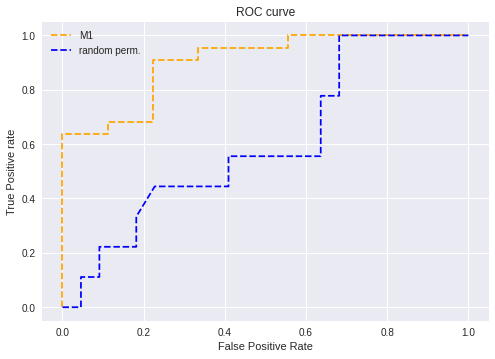

In [42]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='M1')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='random perm.')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
# plt.show();

In [43]:
y_hats, y_labels = [], []

for i, item in tqdm(enumerate(loader)):
    y_hat, y_label = score(item, verbose=False)
    y_hats.append(y_hat)
    y_labels.append(y_label)

y_hats = np.concatenate(y_hats, 0)
y_labels = np.concatenate(y_labels, 0)

print(y_hats.shape)
print(y_labels.shape)

0it [00:00, ?it/s]

(8100,)
(8100,)


In [44]:
print(y_hats[:20])
print(y_labels[:20])

[ 0.14683615 -0.16596049  0.5723674   0.66562784  0.8230142   1.2776796
  1.3887539   1.1842973   2.0151188   1.554503    2.9044888   0.75910497
  0.93049324  0.97752917  1.6427394   1.0282954   1.0893372   0.9374846
  1.5118687   1.5039088 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [45]:
print('PREDS:', y_hats)
fpr1, tpr1, thresh1 = roc_curve(y_labels, y_hats, pos_label=1)
print('FPR:', fpr1, 'TPR:', tpr1, 'THRESHOLDS:', thresh1)
# fpr2, tpr2, thresh2 = roc_curve(y_label, y_hat, pos_label=1)

# roc curve for tpr = fpr 
# random_probs = [0 for i in range(len(y_labels))]
# random_probs = np.random.permutation(y_hats)
# print('RANDOM PREDS:', random_probs)
# p_fpr, p_tpr, _ = roc_curve(y_labels, random_probs, pos_label=0)
# print(p_fpr, p_tpr)

# auc scores
auc_score1 = roc_auc_score(y_labels, y_hats)
# auc_score2 = roc_auc_score(y_labels, random_probs)
print(auc_score1)
# print(auc_score2)

PREDS: [ 0.14683615 -0.16596049  0.5723674  ...  1.771215    1.6943967
  3.5092232 ]
FPR: [0.         0.         0.         ... 0.63474621 0.63474621 1.        ] TPR: [0.00000000e+00 4.22475708e-04 6.63286861e-02 ... 9.99577524e-01
 1.00000000e+00 1.00000000e+00] THRESHOLDS: [  7.438606    6.438606    4.029421  ...  -5.2227206  -5.2240343
 -10.268526 ]
0.9365280175528228


In [46]:
print(fpr1.shape, tpr1.shape, thresh1.shape)


(1499,) (1499,) (1499,)


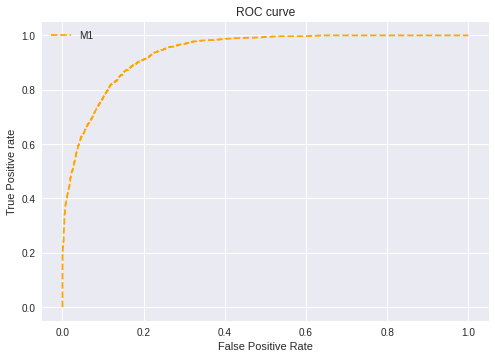

In [47]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='M1')
# plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
# plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
# plt.show();